## Herso 1 sailing alone
### Estimate the power-speed relationship

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "use_V_g_profile":False,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2020,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 7, 801)          # ship sailing speeds to water, (m/s)
# V_s_km_h =  np.linspace(3,20,35)

h_0 = [3, 5.5, 6.5, 7.5, 10.6]        # water depths,(m)
T = [2]   # draught


### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T,h_0,V_s
4000,2,10.6,6.965500
4001,2,10.6,6.974125
4002,2,10.6,6.982750
4003,2,10.6,6.991375
4004,2,10.6,7.000000


### Run OpenTNSim to Calculate resistance, required power and emissions 

In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    
    data_vessel_i = data_vessel.copy()
    
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T']
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    # h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    # print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s, h_0)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    (eta_D, P_d,P_propulsion,P_tot,P_given) = vessel.calculate_total_power_required(V_s, h_0)

    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f'] = R_f
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['eta_D'] = eta_D
    result['P_d'] = P_d
    result['P_B'] = P_propulsion

    results.append(result)

4005it [00:02, 1503.68it/s]


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.tail()

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,eta_D,P_d,P_B,V_s_km
4000,2.0,10.6,6.965500,780.0,39.206475,48.137422,4.900809,103.043463,21.619059,177.700754,0.49,2526.070615,2577.623077,25.07580
4001,2.0,10.6,6.974125,780.0,39.297240,48.248863,4.912155,104.338998,21.671611,179.171626,0.49,2550.133299,2602.176836,25.10685
4002,2.0,10.6,6.982750,780.0,39.388103,48.360424,4.923513,105.569090,21.724182,180.577209,0.49,2573.317363,2625.834044,25.13790
4003,2.0,10.6,6.991375,780.0,39.479064,48.472105,4.934883,106.729649,21.776773,181.913410,0.49,2595.560957,2648.531589,25.16895
4004,2.0,10.6,7.000000,780.0,39.570124,48.583908,4.946265,107.816930,21.829382,183.176485,0.49,2616.806934,2670.211158,25.20000


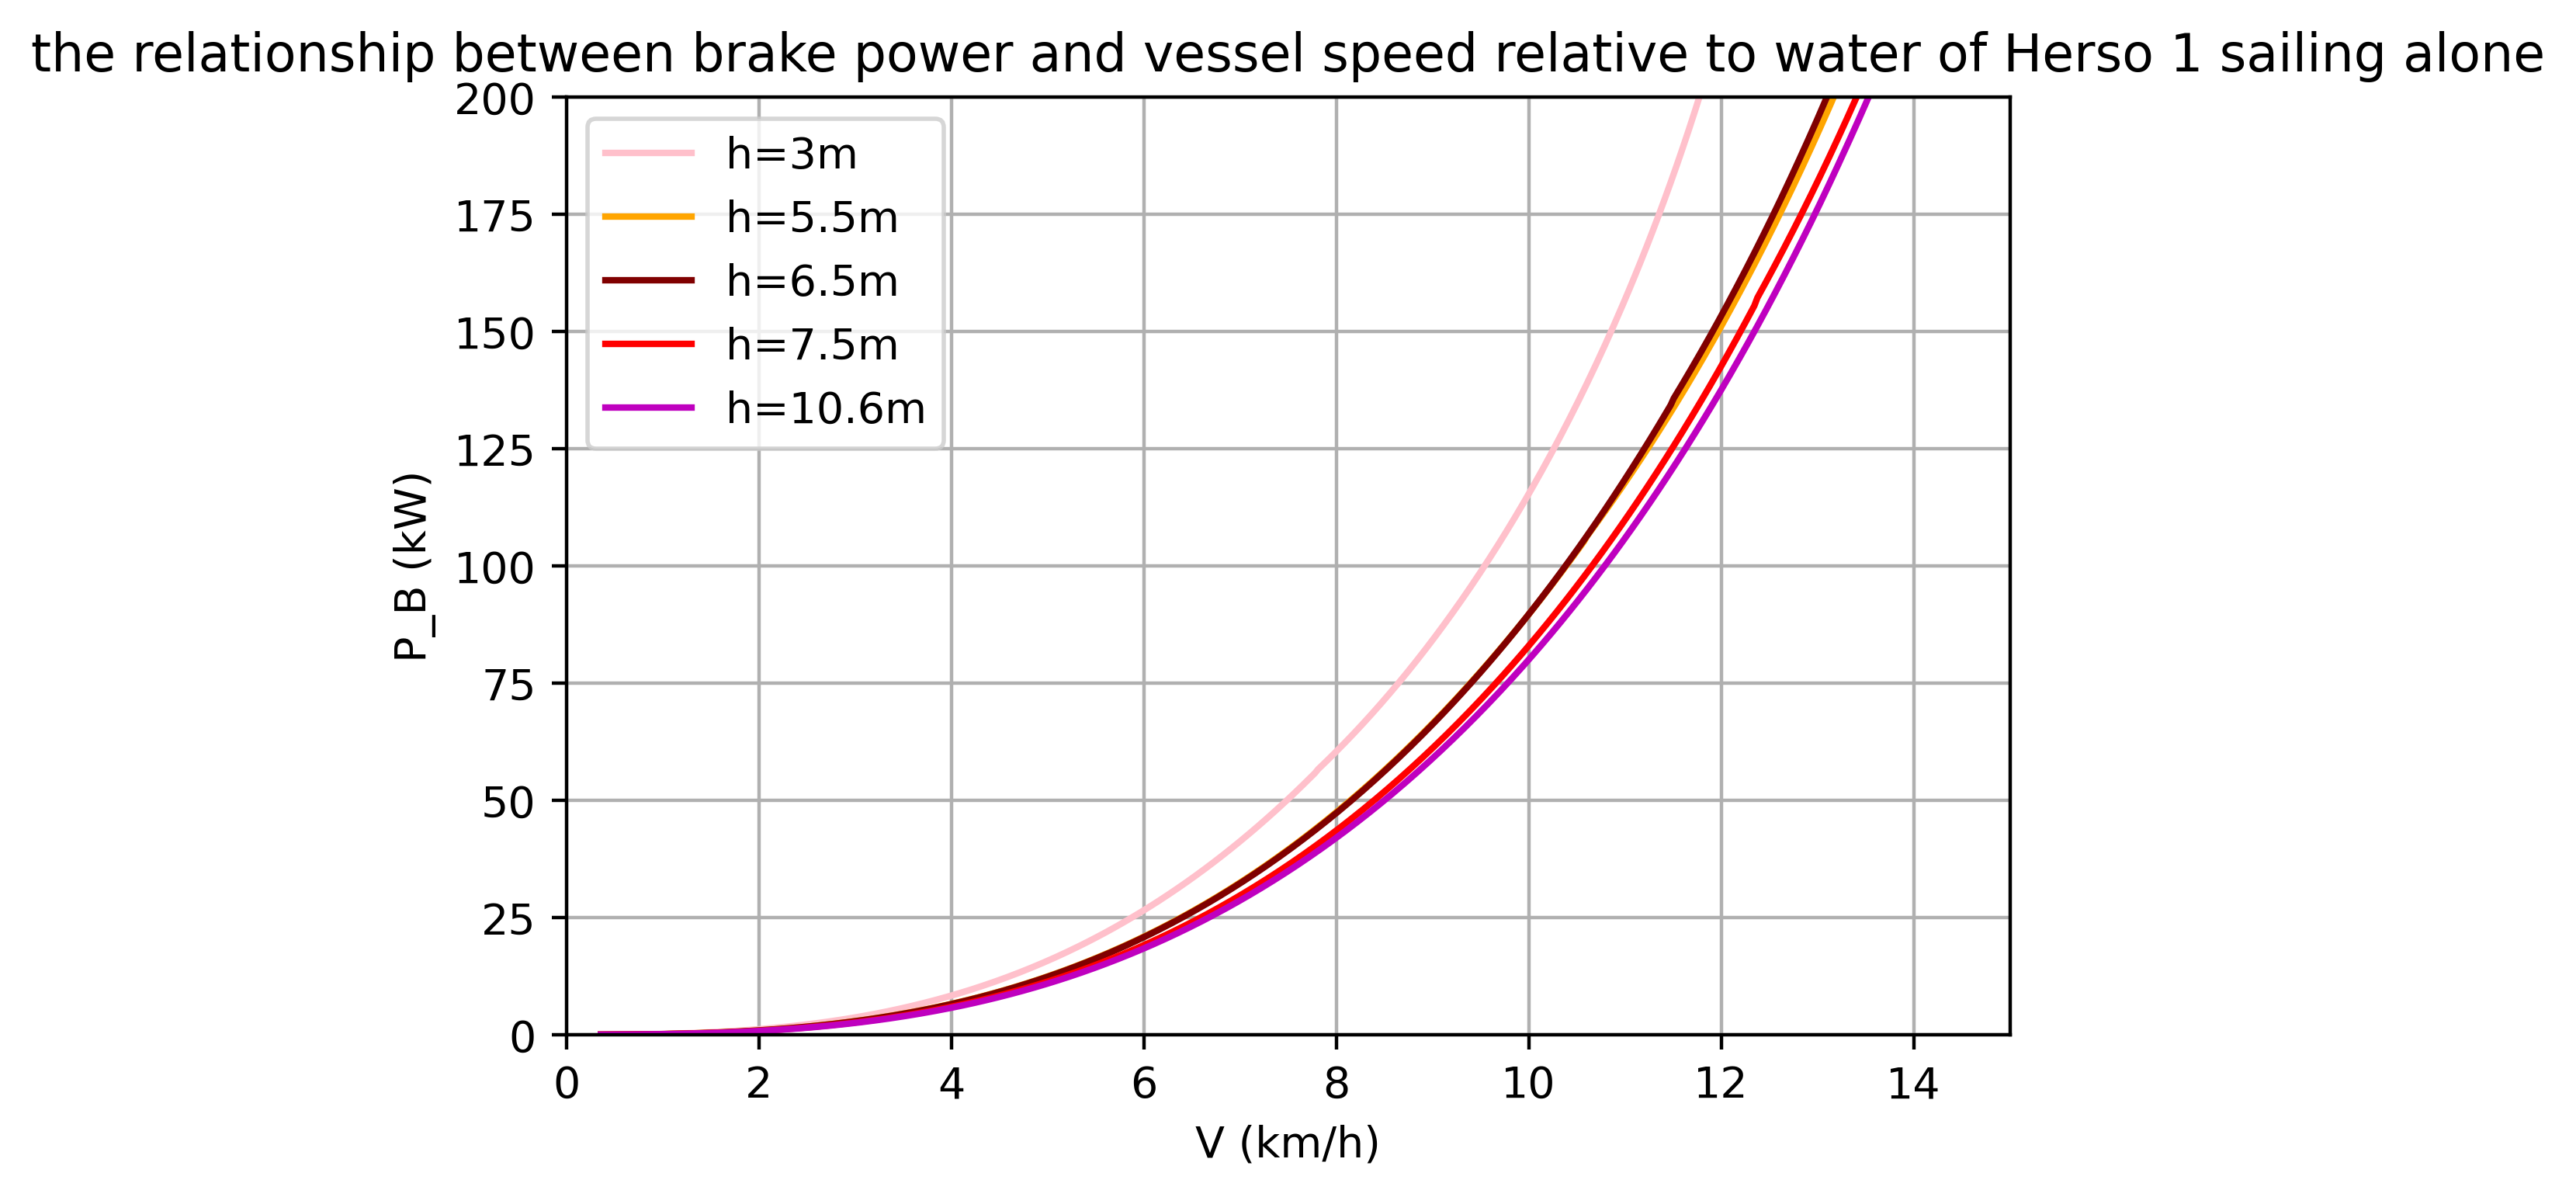

In [12]:
selected_h_3 = plot_df.query('h_0 == 3 & P_B < P_installed')
selected_h_5_5 = plot_df.query('h_0 == 5.5 & P_B < P_installed')
selected_h_6_5 = plot_df.query('h_0 == 6.5 & P_B < P_installed')
selected_h_7_5 = plot_df.query('h_0 == 7.5 & P_B < P_installed')
selected_h_10_6 = plot_df.query('h_0 == 10.6 & P_B < P_installed')

plt.figure(dpi=400)
plt.plot(selected_h_3['V_s_km'],selected_h_3['P_B'], 'pink', linewidth = 1.5)
plt.plot(selected_h_5_5['V_s_km'],selected_h_5_5['P_B'], 'orange', linewidth = 1.5)
plt.plot(selected_h_6_5['V_s_km'],selected_h_6_5['P_B'], 'maroon', linewidth = 1.5)
plt.plot(selected_h_7_5['V_s_km'],selected_h_7_5['P_B'], 'r', linewidth = 1.5)
plt.plot(selected_h_10_6['V_s_km'],selected_h_10_6['P_B'], 'm', linewidth = 1.5)


plt.xlabel('V (km/h)')
plt.ylabel('P_B (kW)')
plt.legend(['h=3m','h=5.5m','h=6.5m','h=7.5m','h=10.6m'])
plt.grid()
plt.xlim(0, 15)
plt.ylim(0,200)
plt.title('the relationship between brake power and vessel speed relative to water of Herso 1 sailing alone');

### 
The not-so-smooth parts you see at the upper end of the graph are so-called 'humps and hollows of the wave resistance'. At certain speeds the waves generated at the bow, stern, forward shoulder and aft shoulder (shoulder = transition area from strongly curved bow and stern sections to parallel midbody) partially cancel each other out, while at other speeds they strengthen each other. This is caused by the fact that wave length is dependent on speed.

The humps and hollows found by Holtrop & Mennen's method are really specific to the shape of the ship, which is not identical for all ships. 